# Luca Corsetti 0001131095

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.model_selection import ParameterGrid

%matplotlib inline

random_state = 777

np.random.seed(random_state)

Consider exam_superv.csv, explore the data, exclude the column texttty and find the best clustering scheme and hyper parameters which can reproduce
the column y. Then apply the clustering scheme found in the previous step to exam_unsuperv.csv and plot the data with the assigned labels
The solution must be produced as a Python Notebook, assuming that the dataset is in the same folder as the notebook.

The notebook must include appropriate comments and must operate as follows:
1. Load the dataset1.csv and explore the data, showing size, structure
and histograms of numeric data; show the histogram of the frequencies
of the class labels, contained in the “y” column . . . . . . . . . . . . . . . . . . . 4pt
2. drop the column “y” and find the best clustering scheme and hyper–
parameters able to reproduce the y column (hint: before clustering you
can consider dropping columns with little correlation to “y”; perhaps
you should consider more than one estimator for clustering) . . . . . 10pt
3. show the difference between the original “y” column and the labels generated by the clustering, it can be expressed as “accuracy”, produce also
the confusion matrix . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4pt
4. apply the same transformations, to dataset2.csv, then apply the best
clustering scheme and hyper parameters and plot the data with the
assigned labels . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 6pt

### 1. Load the dataset1.csv and explore the data, showing size, structure and histograms of numeric data; show the histogram of the frequencies of the class labels, contained in the “y” column

In [2]:
df = pd.read_csv('./exam_superv.csv')

df.head()

,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


the data has 3 numeric columns and one 'y' column, likely to be our "gold standard"

In [3]:
df.describe()

,0,1,y,2
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,2.391668,1.996186,0.507500,2.494236
std,0.804770,0.507227,0.500152,0.589235
min,0.343023,0.509424,0.000000,1.500260
25%,1.806657,1.809635,0.000000,1.974389
50%,2.744439,1.983524,1.000000,2.469778
75%,3.092275,2.201484,1.000000,2.995198
max,3.529782,3.647299,1.000000,3.498523


array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

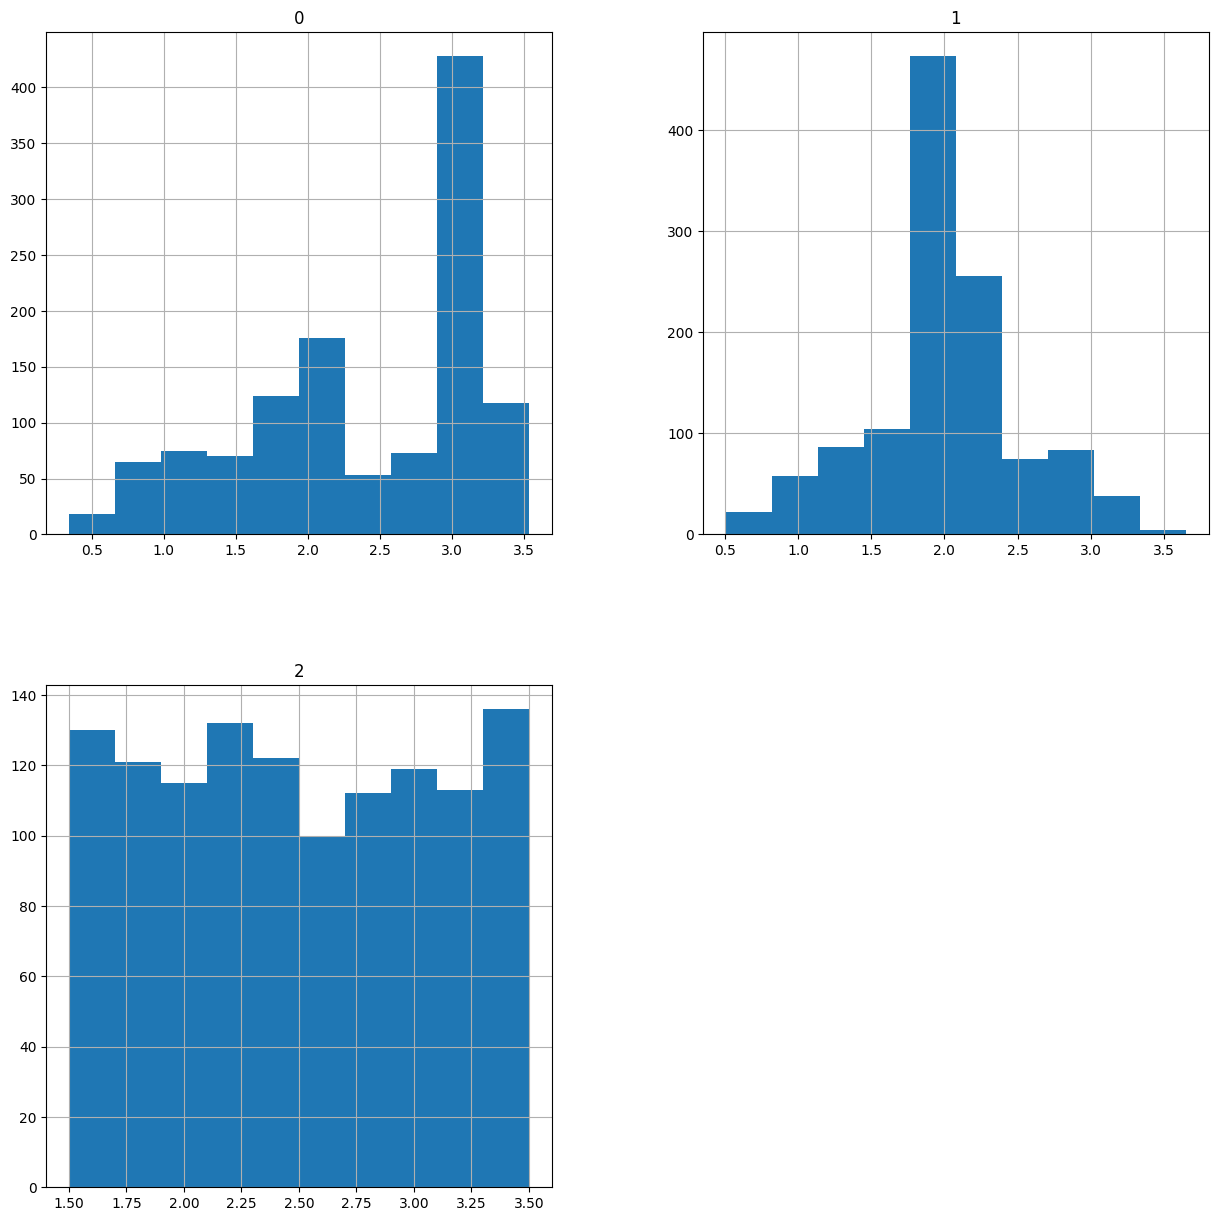

In [4]:
df.drop('y', axis=1).hist(figsize=(15, 15))

the data seems to be quite evenly spread, we do not observe any anomalies regarding distributions.

<Axes: ylabel='Frequency'>

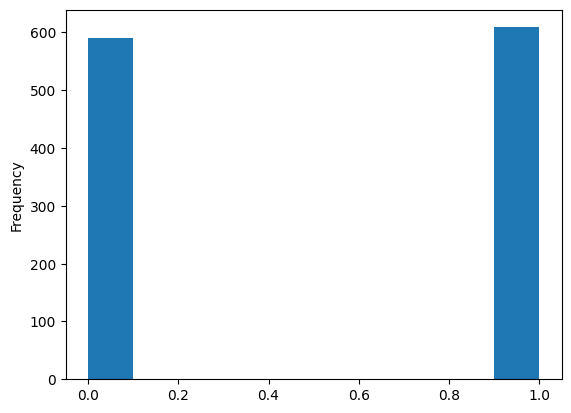

In [5]:
y = df['y']

y.plot.hist()

there are about the same number of '0' and '1' classes in the dataset

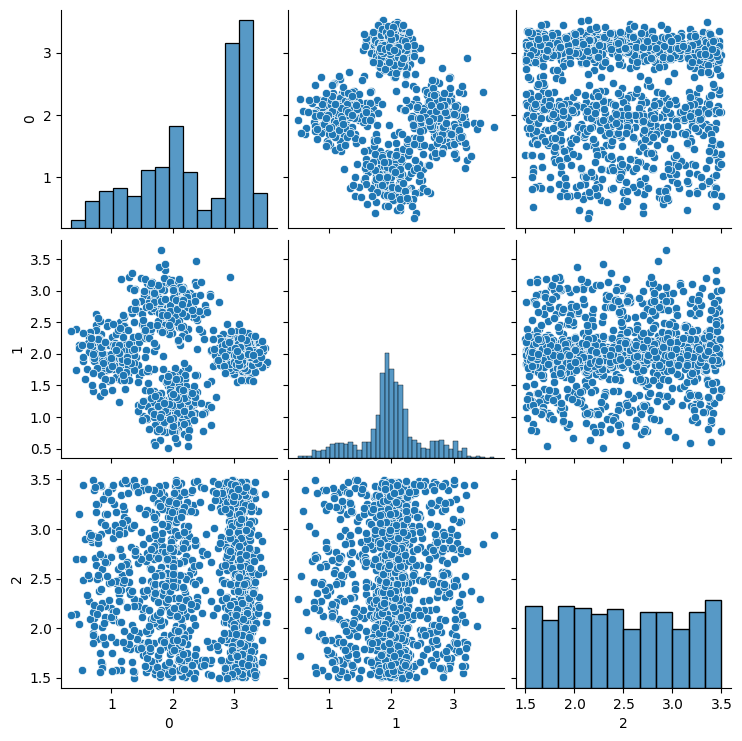

In [6]:
sns.pairplot(df.drop(columns='y'))

by looking at the pairplot, we can cleary distinguish the clusters. hinting that we will likely have 3 (0, 2), (1, 2) or 4 (0, 1). this is strange because the dataset came with only 2 'y' values.

### 2. drop the column “y” and find the best clustering scheme and hyper–parameters able to reproduce the y column (hint: before clustering you can consider dropping columns with little correlation to “y”; perhaps you should consider more than one estimator for clustering)

In [7]:
df = df.drop(columns=['y'])

df.corrwith(y)

0    0.874676
1   -0.000336
2    0.042789
dtype: float64

since the column '1' seems to be having low correlation with our labels 'y', we drop it

In [8]:
X = df.drop(columns=['1'])

we can now proceed on looking for the best clustering scheme, we will use *KMeans* and *AgglomerativeClustering*.\
we will try with a bunch of parameters to find the best one according to the metric 'able to reproduce the y column'

In [46]:
k_range = range(2, 15)

k_means_res = pd.DataFrame(columns=['k', 'silhouette', 'inertia', 'accuracy'])

for k in k_range:
    km = KMeans(n_clusters=k, random_state=random_state)

    y_pred = km.fit_predict(X)

    k_means_res.loc[len(k_means_res)] = [k, silhouette_score(X, y_pred), km.inertia_, accuracy_score(y, y_pred)]

let's plot them to better visualize the result and pick the best k

[]

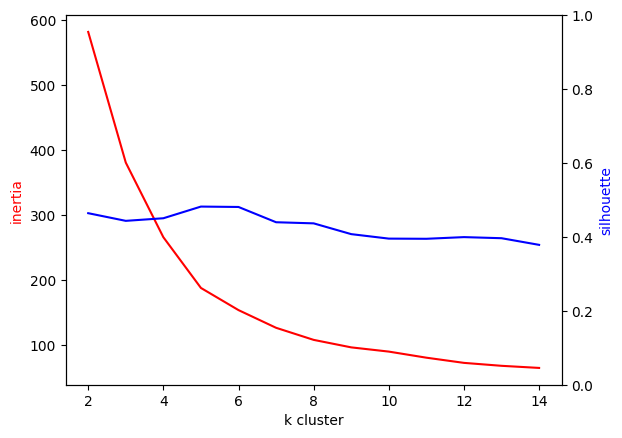

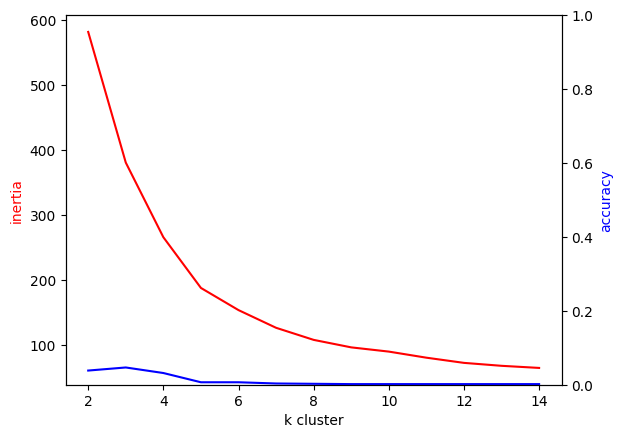

In [75]:
fig, ax = plt.subplots()

ax.set_xlabel('k cluster')
ax.set_ylabel('inertia', color='red')
ax.plot(k_range, k_means_res['inertia'], color='red')

ax1 = ax.twinx()
ax1.set_ylabel('silhouette', color='blue')
ax1.plot(k_range, k_means_res['silhouette'], color='blue')
ax1.set_ylim(0, 1)

plt.plot()

fig, ax = plt.subplots()

ax.set_xlabel('k cluster')
ax.set_ylabel('inertia', color='red')
ax.plot(k_range, k_means_res['inertia'], color='red')

ax1 = ax.twinx()
ax1.set_ylabel('accuracy', color='blue')
ax1.plot(k_range, k_means_res['accuracy'], color='blue')
ax1.set_ylim(0, 1)

plt.plot()

3 or 4 seems to be the best k to choose for k_means as it's the point at which inertia seems to slow down meaning that adding clusters is not being that advatangeous anymore.\
however, since we noticed that our initial dataset labelled data with only 2 clusters, it would be wise to choose k=2 even though the accuracy is quite poor.

let's now try with the *AgglomerativeClustering* algorithm

In [47]:
params = [{"n_clusters": k_range, "linkage": ['ward', 'complete', 'average', 'single']}]
grid = list(ParameterGrid(params))

agg_res = pd.DataFrame(columns=['k', 'silhouette', 'linkage', 'accuracy'])

for i in range(len(grid)):
    ag = AgglomerativeClustering(**(grid[i]))

    y_pred = ag.fit_predict(X)

    agg_res.loc[len(agg_res)] = [ag.n_clusters, silhouette_score(X, y_pred), ag.linkage, accuracy_score(y, y_pred)]

agg_res.sort_values(by=['k', 'silhouette'], ascending=[True, False]).head(10)

,k,silhouette,linkage,accuracy
0,2,0.459122,ward,0.013333
26,2,0.457033,average,0.987500
13,2,0.420918,complete,0.865833
39,2,0.349696,single,0.491667
1,3,0.436778,ward,0.755000
27,3,0.415442,average,0.009167
14,3,0.371431,complete,0.134167
40,3,0.266226,single,0.490833
2,4,0.420184,ward,0.598333
28,4,0.403872,average,0.568333


AgglomerativeClustering seems indeed to give us a better result with an accuracy of 0.98%, with k=2, linkage=average and silhouette relatively stable for increasing number of clusters

In [48]:
best_k = 2

### 3. show the difference between the original “y” column and the labels generated by the clustering, it can be expressed as “accuracy”, produce also the confusion matrix

In [76]:
best_k_means = k_means_res[k_means_res['k'] == best_k].iloc[0]
best_agg = agg_res[(agg_res['k'] == 2) & (agg_res['linkage'] == 'average')].iloc[0]

print(f"the best k_means with k={best_k_means['k']} has an accuracy of {best_k_means['accuracy']*100:.2f}%")

print(f"the best agg_clustering with k={best_agg['k']} has an accuracy of {best_agg['accuracy']*100:.2f}%")

the best k_means with k=2.0 has an accuracy of 3.83%
the best agg_clustering with k=2 has an accuracy of 98.75%


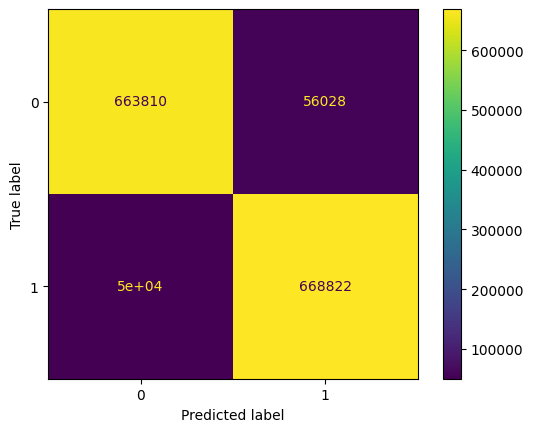

In [82]:
km = KMeans(n_clusters=2)
km_y_pred = km.fit_predict(X)

cmd = ConfusionMatrixDisplay(pair_confusion_matrix(y, km_y_pred))
cmd.plot()

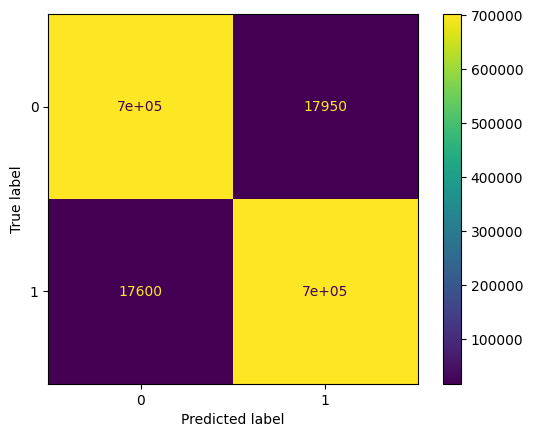

In [83]:
ag = AgglomerativeClustering(n_clusters=2, linkage='average')
ag_y_pred = ag.fit_predict(X)

cmd = ConfusionMatrixDisplay(pair_confusion_matrix(y, ag_y_pred))
cmd.plot()

### 4. apply the same transformations, to dataset2.csv, then apply the best clustering scheme and hyper parameters and plot the data with the assigned labels